# Create WecOptTool Model for the Marson WEC concept

In [100]:
import autograd.numpy as np
import capytaine as cpt
from capytaine.io.meshio import load_from_meshio
import matplotlib.pyplot as plt
from scipy.optimize import brute
import pygmsh
from scipy.linalg import block_diag
import xarray as xr

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

import logging
logging.getLogger().setLevel(logging.INFO)

### Waves and Frequency array

In [101]:
wavefreq = 1/8 # Hz
f1 = wavefreq
nfreq = 10

freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency

amplitude = 0.0625 # m
phase = 30 # degrees
wavedir = 0 # degrees

waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

#### WEC geometry mesh
Now we will create a surface mesh for the WEC hull and store it using the `FloatingBody` object from Capytaine.

INFO:capytaine.io.meshio:Stored 722 triangle faces as quadrilaterals
INFO:capytaine.io.meshio:Stored 722 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: FloatingBody(mesh=Mesh(..., name="mesh_from_meshio_1341"), lid_mesh=Mesh(..., name="lid for Rect"), dofs={}, center_of_mass=[-1.  0.  0.], name="rect0").
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.bodies.bodies:The rotation dof Pitch has been initialized around the point: FloatingBody(..., name="rect0").rotation_center = (-1.0, 0, 0)
INFO:capytaine.bodies.bodies:Clipping rect0 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1341 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0.

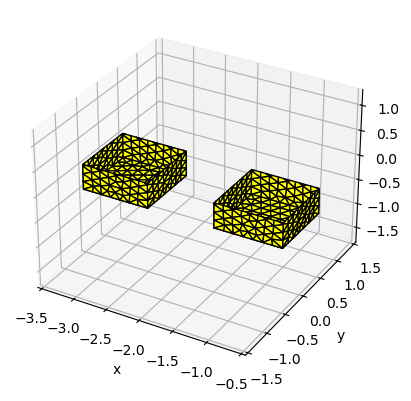

In [102]:
numBodies = 2
bodyDist = 2
bodyLocs = [-0.5*bodyDist, -1.5*bodyDist] #, 3]
mesh_size_factor = 0.16
bodHeight = [1.1, 1.1]
bodDraft = [0.5, 0.5]
bodWidth = [1, 1]
bodLength = [1, 1]

hydrostaticsDict = {}
rect = {}
bodList = []

for nBod in range(numBodies):
    with pygmsh.geo.Geometry() as geom:
        poly1 = geom.add_polygon(
            [[bodyLocs[nBod]-bodWidth[nBod]/2, bodLength[nBod]/2],
            [bodyLocs[nBod]-bodWidth[nBod]/2,-bodLength[nBod]/2],
            [bodyLocs[nBod]+bodWidth[nBod]/2,-bodLength[nBod]/2],
            [bodyLocs[nBod]+bodWidth[nBod]/2,bodLength[nBod]/2]],mesh_size=mesh_size_factor)
        
        geom.translate(poly1, [0, 0, bodHeight[nBod]-bodDraft[nBod]])
        geom.extrude(poly1,[0,0,-bodHeight[nBod]])
        rectMesh = geom.generate_mesh()
        meshObj = load_from_meshio(rectMesh, 'Rect')
        lidMesh = meshObj.generate_lid(z=-.05)

        # define the floating body
        rect[nBod] = cpt.FloatingBody(mesh=rectMesh, lid_mesh = lidMesh, name="rect"+str(nBod), center_of_mass=(bodyLocs[nBod], 0, 0))
        rect[nBod].keep_immersed_part()

        rect[nBod].center_of_mass = (bodyLocs[nBod], 0, 0)
        rect[nBod].rotation_center = rect[nBod].center_of_mass
        
        # solve about standard 3 degrees of freedom
        rect[nBod].add_translation_dof(name="Surge")
        rect[nBod].add_translation_dof(name="Heave")
        rect[nBod].add_rotation_dof(name="Pitch")

        rect[nBod].inertia_matrix = rect[nBod].compute_rigid_body_inertia()
        rect[nBod].hydrostatic_stiffness = rect[nBod].immersed_part().compute_hydrostatic_stiffness()

        bodList.append(rect[nBod])

all_bodies = cpt.FloatingBody.join_bodies(*bodList)

#allBodies.show_matplotlib()
all_bodies.show_matplotlib()
ndof = all_bodies.nb_dofs


In [103]:
print(rect[0].inertia_matrix) # verified analytically
print(rect[1].inertia_matrix) 


<xarray.DataArray 'inertia_matrix' (influenced_dof: 3, radiating_dof: 3)> Size: 72B
array([[500.        ,   0.        ,   0.        ],
       [  0.        , 500.        ,  -0.        ],
       [  0.        ,  -0.        ,  82.75285645]])
Coordinates:
  * influenced_dof  (influenced_dof) <U5 60B 'Surge' 'Heave' 'Pitch'
  * radiating_dof   (radiating_dof) <U5 60B 'Surge' 'Heave' 'Pitch'
<xarray.DataArray 'inertia_matrix' (influenced_dof: 3, radiating_dof: 3)> Size: 72B
array([[500.        ,   0.        ,   0.        ],
       [  0.        , 500.        ,  -0.        ],
       [  0.        ,  -0.        ,  82.74846563]])
Coordinates:
  * influenced_dof  (influenced_dof) <U5 60B 'Surge' 'Heave' 'Pitch'
  * radiating_dof   (radiating_dof) <U5 60B 'Surge' 'Heave' 'Pitch'


In [104]:
bem_data = wot.run_bem(all_bodies, freq, wave_dirs=0)

INFO:capytaine.green_functions.delhommeau:Loading tabulation from C:\Users\jtgrasb\AppData\Local\capytaine\Cache\2.2\tabulation_float64_scaled_nemoh3_676_100.0_372_-251.0_1001.npz


[16:20:37] WARNING  Using the geometric centroid as the center of gravity (COG).

           WARNING  Using the center of gravity (COG) as the rotation center for hydrostatics. Note that the       
                    hydrostatics do not use the axes defined by the FloatingBody degrees of freedom, and the       
                    rotation center should be set manually when using Capytaine to calculate hydrostatics about an 
                    axis other than the COG.

INFO:capytaine.bodies.bodies:Clipping copy_of_rect0+rect1 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1341 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping mesh_from_meshio_1353 by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping lid for Rect by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.


Output()

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=0.785, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=0.785, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=1.571, water_depth=inf, radiating_dof='rect1__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=2.356, water_depth=inf, radiating_dof='rect1__Pitch', rho=1025.0).


INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.142, water_depth=inf, radiating_dof='rect1__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_

INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.927, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.927, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.927, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.927, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=3.927, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=4.712, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=4.712, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=4.712, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=4.712, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=4.712, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=4.712, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of

INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=5.498, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=5.498, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=5.498, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=5.498, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=5.498, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of

INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=6.283, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=6.283, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=6.283, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=6.283, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=6.283, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=6.283, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of

INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.069, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.069, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.069, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.069, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.069, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.069, water_depth=inf, radiating_dof='rect1__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.854, water_depth=inf, wave_direction=0.000, rho=1025.0).


INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.854, water_depth=inf, radiating_dof='rect0__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.854, water_depth=inf, radiating_dof='rect0__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.854, water_depth=inf, radiating_dof='rect0__Pitch', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.854, water_depth=inf, radiating_dof='rect1__Surge', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of_rect0+rect1_immersed"), omega=7.854, water_depth=inf, radiating_dof='rect1__Heave', rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=FloatingBody(..., name="copy_of

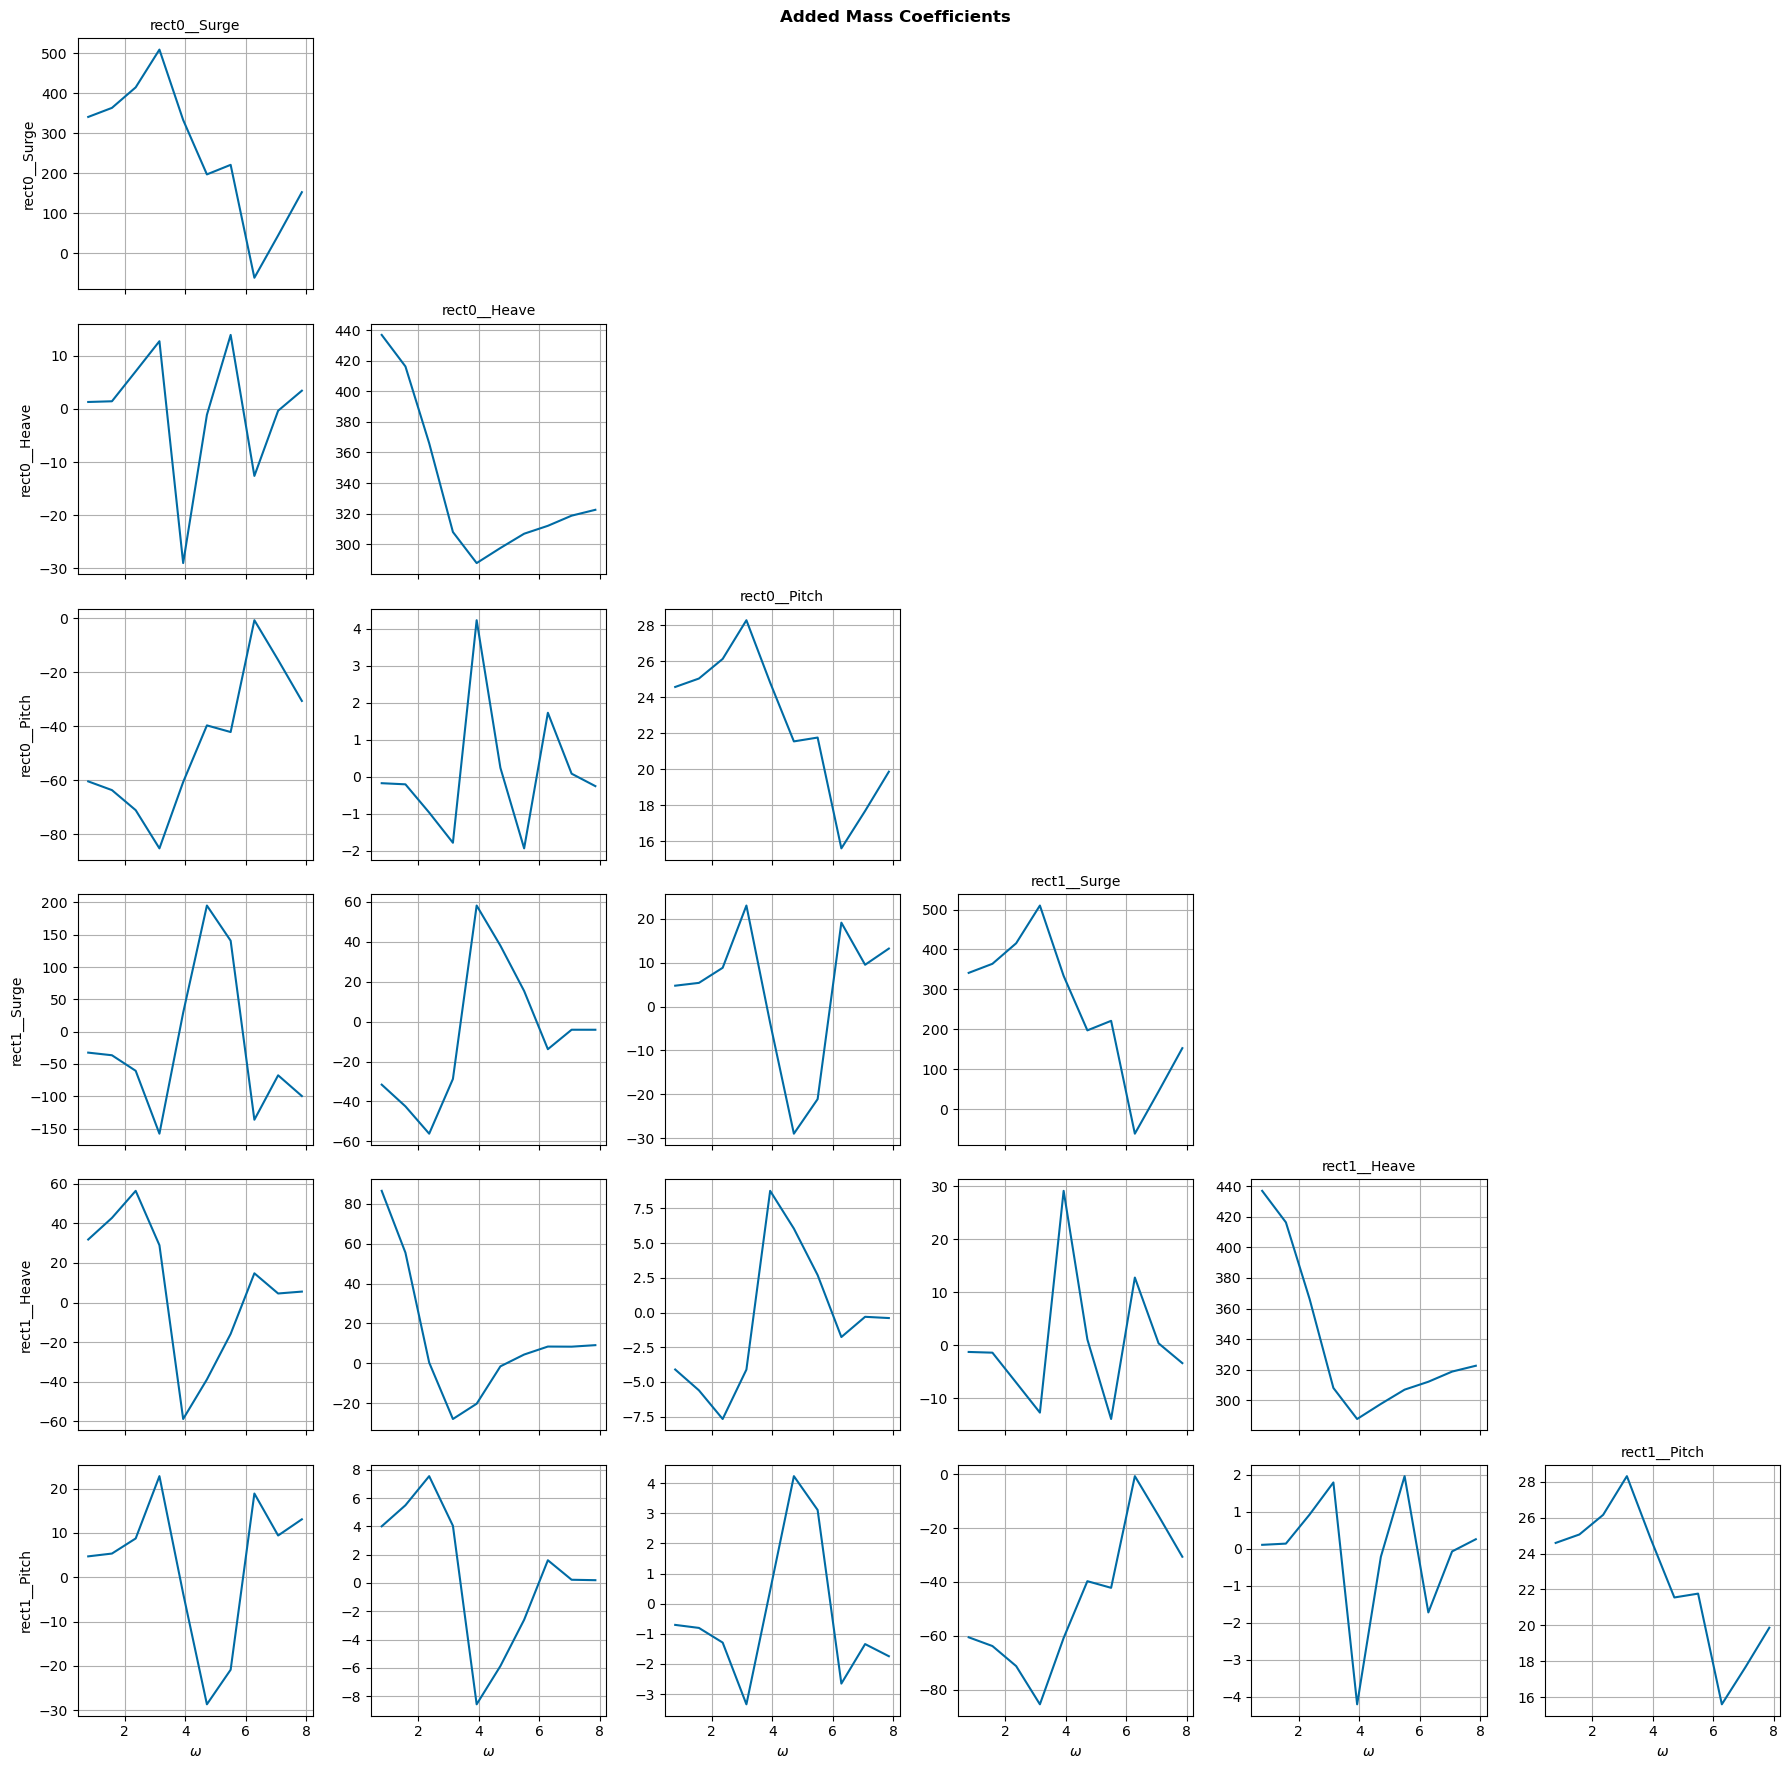

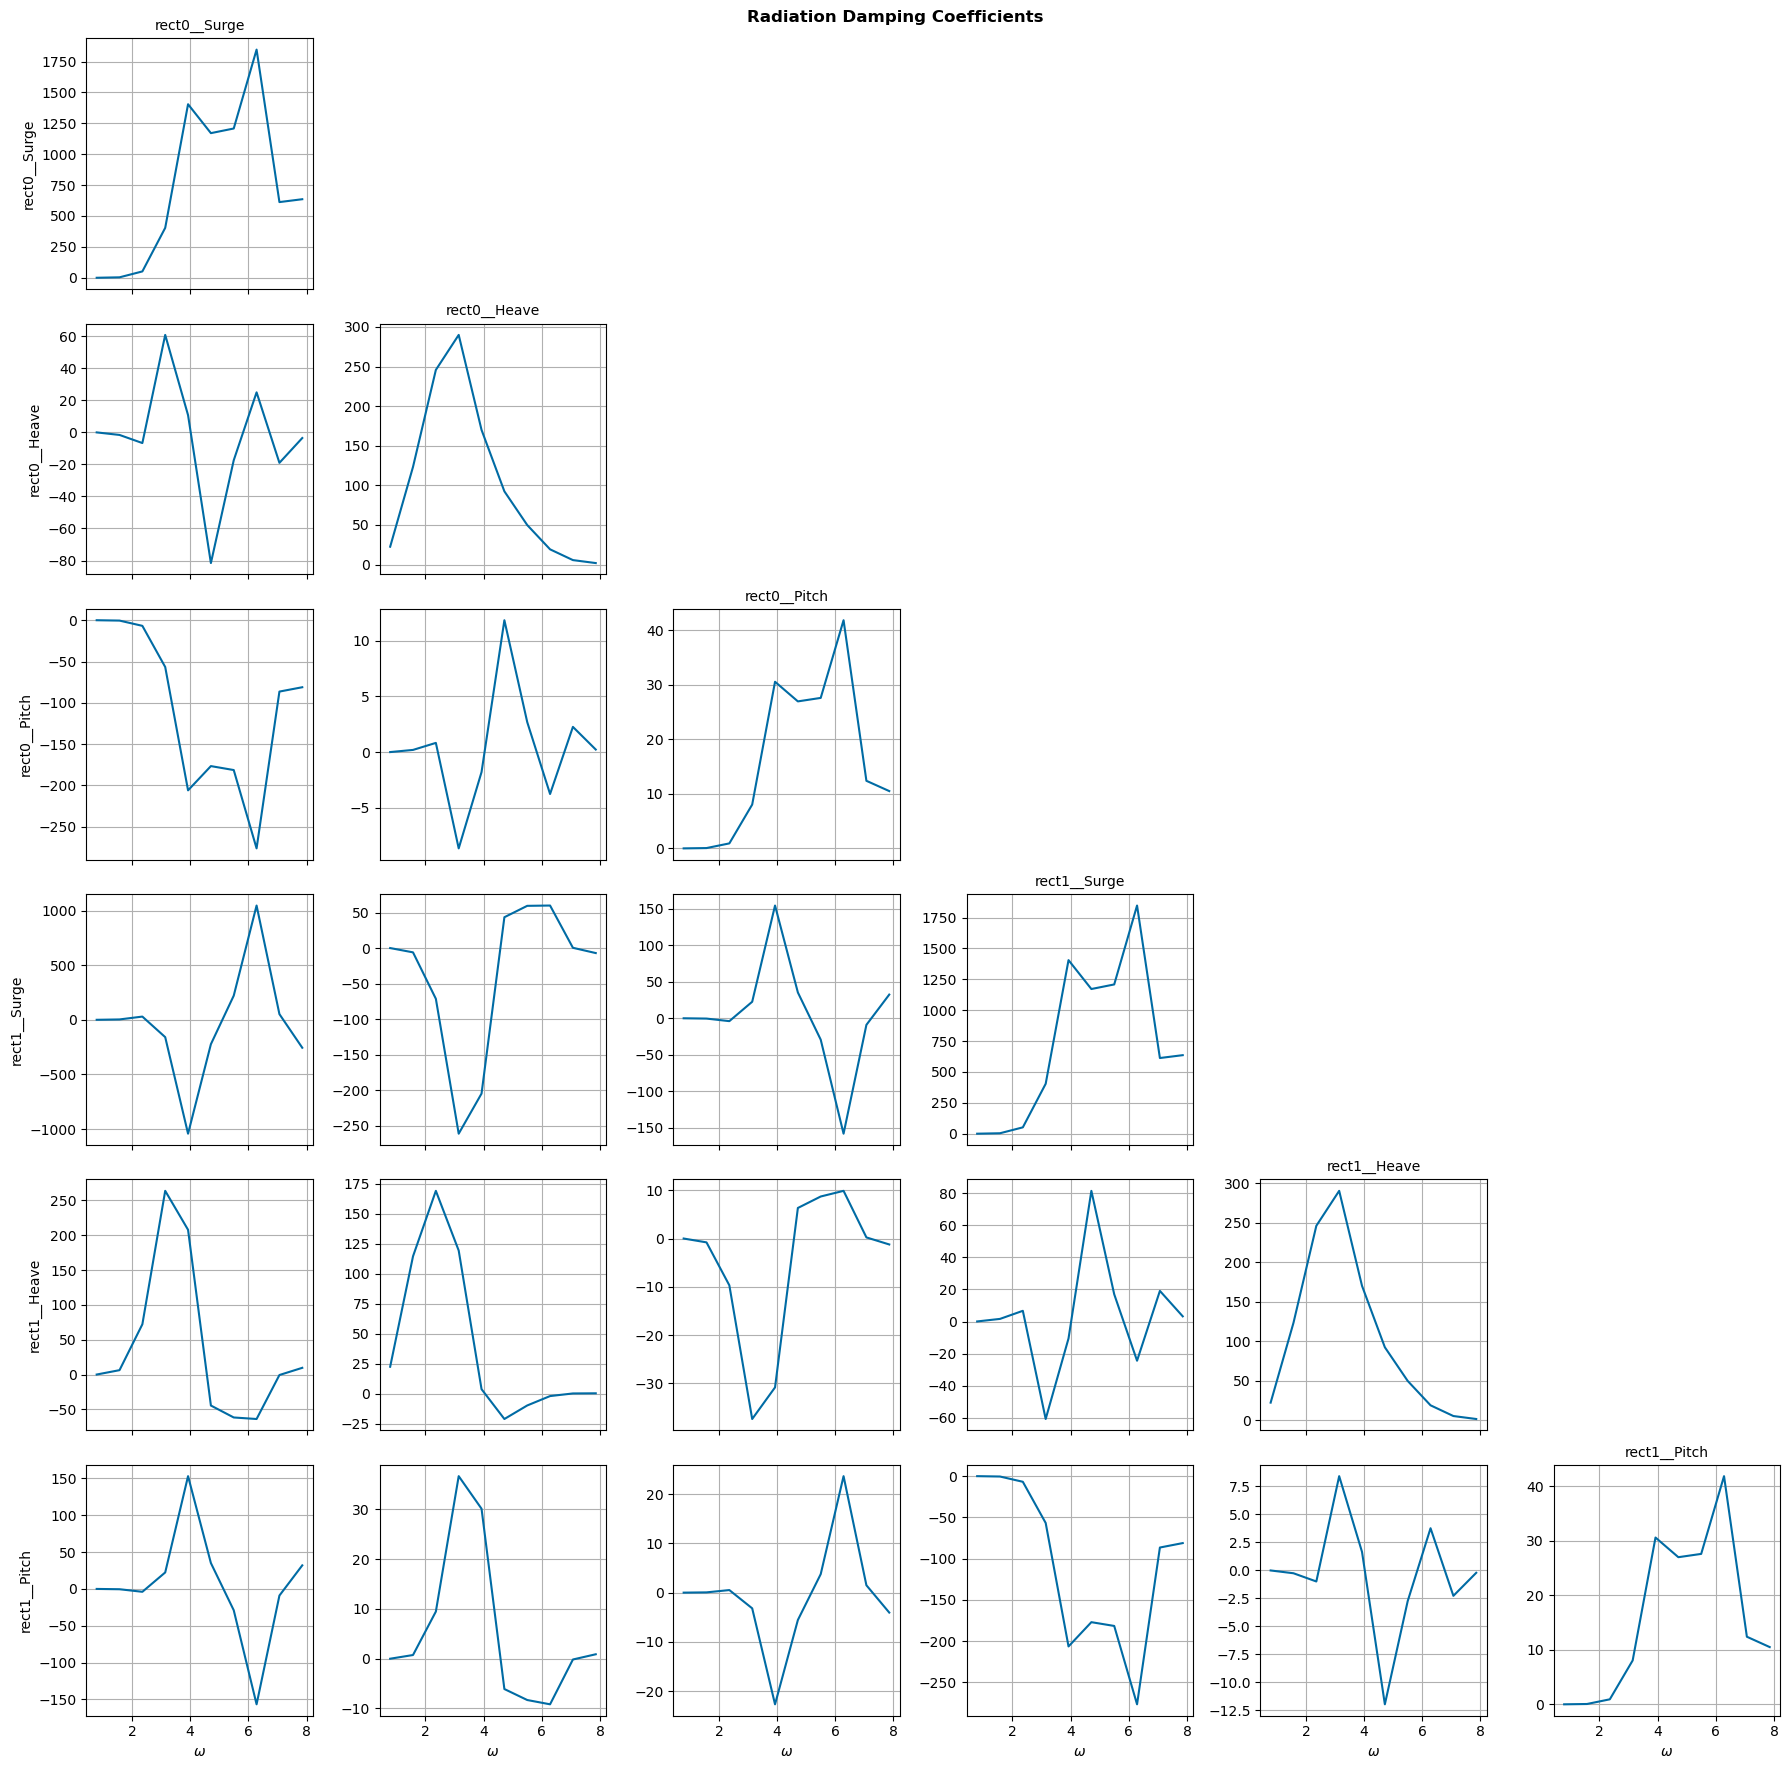

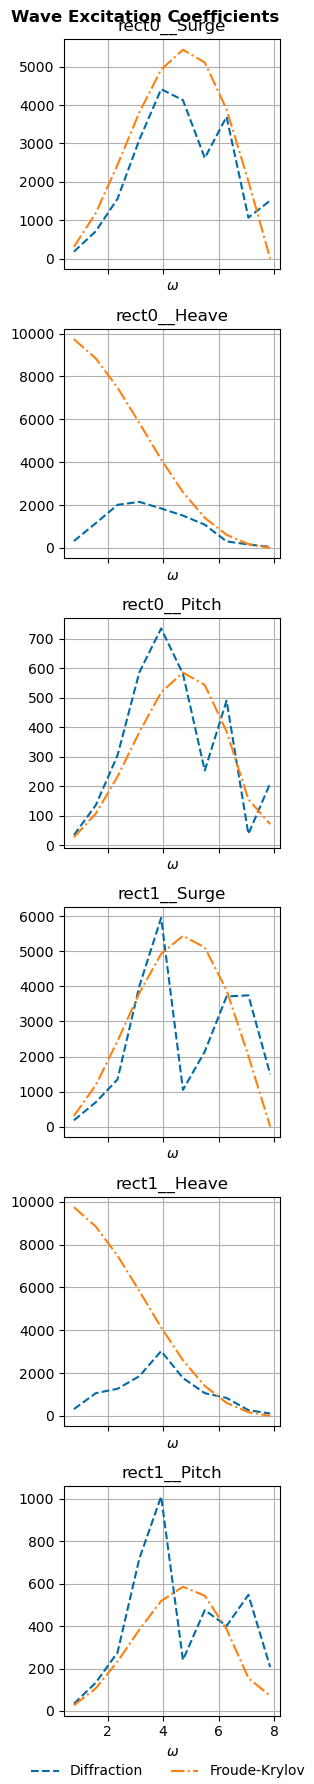

In [105]:
bem_data_plot = bem_data.sel(wave_direction = 0, method='nearest')
radiating_dofs = bem_data_plot.radiating_dof.values
influenced_dofs = bem_data_plot.influenced_dof.values

# plots
fig_am, ax_am = plt.subplots(
    len(radiating_dofs), 
    len(influenced_dofs),
    tight_layout=True, 
    sharex=True, 
    figsize=(3*len(radiating_dofs),3*len(influenced_dofs)),
    squeeze=False
    )
fig_rd, ax_rd = plt.subplots(
    len(radiating_dofs),
    len(influenced_dofs),
    tight_layout=True,
    sharex=True, 
    figsize=(3*len(radiating_dofs), 3*len(influenced_dofs)),
    squeeze=False
    )
fig_ex, ax_ex = plt.subplots(
    len(influenced_dofs),
    1,
    tight_layout=True, 
    sharex=True, 
    figsize=(3, 3*len(radiating_dofs)), 
    squeeze=False
    )
[ax.grid(True) for axs in (ax_am, ax_rd, ax_ex) for ax in axs.flatten()]
# plot titles
fig_am.suptitle('Added Mass Coefficients', fontweight='bold')
fig_rd.suptitle('Radiation Damping Coefficients', fontweight='bold')
fig_ex.suptitle('Wave Excitation Coefficients', fontweight='bold')

sp_idx = 0
for i, rdof in enumerate(radiating_dofs):
    for j, idof in enumerate(influenced_dofs):
        sp_idx += 1
        if i == 0:
            np.abs(bem_data_plot.diffraction_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashed', label='Diffraction')
            np.abs(bem_data_plot.Froude_Krylov_force.sel(influenced_dof=idof)).plot(
                ax=ax_ex[j,0], linestyle='dashdot', label='Froude-Krylov')
            ex_handles, ex_labels = ax_ex[j,0].get_legend_handles_labels()
            ax_ex[j,0].set_title(f'{idof}')
            ax_ex[j,0].set_xlabel('')
            ax_ex[j,0].set_ylabel('')
        if j <= i:
            bem_data_plot.added_mass.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_am[i, j])
            bem_data_plot.radiation_damping.sel(
                radiating_dof=rdof, influenced_dof=idof).plot(ax=ax_rd[i, j])
            if i == len(radiating_dofs)-1:
                ax_am[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_rd[i, j].set_xlabel(f'$\omega$', fontsize=10)
                ax_ex[j, 0].set_xlabel(f'$\omega$', fontsize=10)
            else:
                ax_am[i, j].set_xlabel('')
                ax_rd[i, j].set_xlabel('')
            if j == 0:
                ax_am[i, j].set_ylabel(f'{rdof}', fontsize=10)
                ax_rd[i, j].set_ylabel(f'{rdof}', fontsize=10)
            else:
                ax_am[i, j].set_ylabel('')
                ax_rd[i, j].set_ylabel('')
            if j == i:
                ax_am[i, j].set_title(f'{idof}', fontsize=10)
                ax_rd[i, j].set_title(f'{idof}', fontsize=10)
            else:
                ax_am[i, j].set_title('')
                ax_rd[i, j].set_title('')
        else:
            fig_am.delaxes(ax_am[i, j])
            fig_rd.delaxes(ax_rd[i, j])
fig_ex.legend(ex_handles, ex_labels, loc=(0.08, 0), ncol=2, frameon=False)

In [106]:
import multibody as mb
import sympy
import m4e_attenuator as ex

MBDsys = mb.MBDSystem.from_example(ex)

# Print the original rotation matrix
print("Original Rotation Matrix (R):")
print(MBDsys.R)

substitution_dict = {var: 0 for var in MBDsys.R.free_symbols}
R_subs = MBDsys.R.subs(substitution_dict)
print("Substituted Rotation Matrix (R_subs):")
print(np.array(R_subs))

# mass and inertia properties
mass1 = 0.5*1000
mass2 = 0.5*1000
inertia1 = (1/12)*0.5*1000*(1**2 + 1**2)
inertia2 = (1/12)*0.5*1000*(1**2 + 1**2)
theta1 = 0
theta2 = 0

# Print the original rotation matrix
print("Original Mass Matrix (ReducedM):")
print(MBDsys.ReducedM)

vals = [inertia1,theta2,theta1,inertia2,mass1,mass2] # order based on free_symbols

substitution_dict = {var: val for var, val in zip(MBDsys.ReducedM.free_symbols, vals)}
ReducedM_subs = MBDsys.ReducedM.subs(substitution_dict)
print("Substituted Mass Matrix (ReducedM_subs):")
print(np.array(ReducedM_subs))

Problem initialization finished in:		 0.004 seconds
All branches in the graph:
Branch 1: [1, 2]
R and RD matrices calculation finished in:	 0.115 seconds
Symbolic EOM computation finished in:		 0.055 seconds
Compiling EOM expressions finished in:		 0.196 seconds
Original Rotation Matrix (R):
Matrix([[sin(Theta_1), 0], [cos(Theta_1), 0], [1, 0], [3*sin(Theta_1), sin(Theta_2)], [3*cos(Theta_1), cos(Theta_2)], [0, 1]])
Substituted Rotation Matrix (R_subs):
[[0 0]
 [1 0]
 [1 0]
 [0 0]
 [3 1]
 [0 1]]
Original Mass Matrix (ReducedM):
Matrix([[J1 + m1*sin(Theta_1)**2 + m1*cos(Theta_1)**2 + 9*m2*sin(Theta_1)**2 + 9*m2*cos(Theta_1)**2, 3*m2*sin(Theta_1)*sin(Theta_2) + 3*m2*cos(Theta_1)*cos(Theta_2)], [3*m2*sin(Theta_1)*sin(Theta_2) + 3*m2*cos(Theta_1)*cos(Theta_2), J2 + m2*sin(Theta_2)**2 + m2*cos(Theta_2)**2]])
Substituted Mass Matrix (ReducedM_subs):
[[5083.33333333333 1500.00000000000]
 [1500.00000000000 583.333333333333]]


In [ ]:
mass_matrix = block_diag(rect[0].inertia_matrix.values,rect[1].inertia_matrix.values)
added_mass = np.squeeze(bem_data['added_mass'].data) # Added mass
radiation_damping = np.squeeze(bem_data['radiation_damping'].data)  # Radiation damping
hydrostatic_stiffness = np.squeeze(bem_data['hydrostatic_stiffness'].data)  # Hydrostatic stiffness
excitation_force = np.squeeze(bem_data['excitation_force'].data) # Excitation force

omega = freq*2*np.pi
impedance_matrix = (mass_matrix + added_mass)*1j*omega[:, np.newaxis, np.newaxis] + radiation_damping - (1j/omega[:, np.newaxis, np.newaxis])*np.repeat(hydrostatic_stiffness[np.newaxis, :, :], 10, axis=0)
impedance_reduced = np.array(R_subs,dtype=np.complex128).T @ impedance_matrix @ np.array(R_subs,dtype=np.complex128)
print(np.shape(impedance_reduced))

hydrostatic_stiffness_reduced = (np.array(R_subs,dtype=np.complex128).T @ hydrostatic_stiffness @ np.array(R_subs,dtype=np.complex128))
print(np.shape(hydrostatic_stiffness_reduced))

excitation_reduced = np.squeeze(bem_data['excitation_force'].values @ np.array(R_subs,dtype=np.complex128))[:,np.newaxis,:]

wave_direction = np.array([wavedir,])
nwave_direction = len(wave_direction)
coords_exc = {
    'omega': (['omega'], omega, {'units': 'rad/s'}),
    'wave_direction': (['wave_direction'], wave_direction, {'units': 'rad'}),
    'influenced_dof': (['influenced_dof'], ['pitch_1', 'pitch_2'], {}),
}
excitation_reduced = xr.DataArray(excitation_reduced, coords=coords_exc, attrs={})

print(np.shape(excitation_reduced))

(10, 2, 2)
(2, 2)
(10, 1, 2)
(10, 1, 2)


In [118]:
wec = wot.WEC.from_impedance(
    freq,
    impedance=impedance_reduced,
    exc_coeff=excitation_reduced,
    hydrostatic_stiffness=hydrostatic_stiffness_reduced,
    constraints=None,
    f_add={},
)

# Objective function
obj_fun = lambda wec, x_wec, x_opt, waves : 0
nstate_opt = 0

# Solve
scale_x_wec = 1e1
scale_x_opt = 1e-3
scale_obj = 1e-2

results = wec.solve(
    waves,
    obj_fun,
    nstate_opt,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
)


INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.


INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [2.62e+00, nan, 0.00e+00]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1


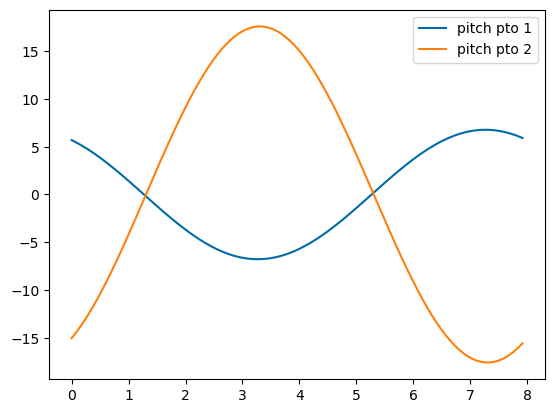

In [132]:
nsubsteps = 5
wec_fdom, wec_tdom = wec.post_process(wec, results, waves, nsubsteps=nsubsteps)


ndof_new = 2
plt.figure()
plt.plot(wec_tdom['time'],wec_tdom.pos[0,0]*180/np.pi)
plt.plot(wec_tdom['time'],wec_tdom.pos[0,1]*180/np.pi)
plt.legend(['pitch pto 1', 'pitch pto 2'])
